In [1]:
from detectron2.data import DatasetCatalog,MetadataCatalog
from plain_train_net import grab_dataset,OutputVis, CreatePlotsRPD
from detectron2.utils.colormap import random_color

import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
plt.style.use('ybpres.mplstyle')
import pandas as pd

In [2]:
dataset_name = "dfeval_train_v2"
has_annotations = False
dfimg = pd.read_csv('output_dfeval_train_v2/dfimg_dfeval_train_v2.csv',index_col=0)
dfvol = dfimg.groupby(['volID']).sum()
vols = dfvol[dfvol.dt_instances>=20].index
grps = dfimg[dfimg.volID.isin(vols)].groupby(['volID'])
#spacing
d = 121.171 #um scan spacing
D = d*60 #um height of the enface area

P = 768 #px scan width in pixels

dpx = d/11.233 #px scan spacing in pixels

In [3]:

DatasetCatalog.register(dataset_name, grab_dataset(dataset_name))
MetadataCatalog.get(dataset_name).thing_classes = [""]
vis =OutputVis(dataset_name,pred_mode='file',pred_file = 'output_'+dataset_name+'/coco_instances_results.json',has_annotations=has_annotations)

In [4]:

dfdata = pd.read_parquet('datasets/dfeval_train_v2_refined.parquet')
dfdata[(dfdata.instance.isin(vols))&(dfdata.slicei==0)].groupby(['ptid','eye']).count()
ptid = '477daf788b31a095c03f5846a5e738dc4800bd8a6679e301b68c051505648b8d'
vols_L = dfdata[(dfdata.ptid==ptid)&(dfdata.eye=='L')][['instance','age','octh','slicei']]
vols_R = dfdata[(dfdata.ptid==ptid)&(dfdata.eye=='R')][['instance','age','octh','slicei']]
grps_L = dfimg.reset_index().merge(vols_L, left_on=['volID','scan'],right_on=['instance','slicei']).set_index('index').drop(columns=['instance','slicei']).groupby(['age'])
grps_R = dfimg.reset_index().merge(vols_R, left_on=['volID','scan'],right_on=['instance','slicei']).set_index('index').drop(columns=['instance','slicei']).groupby(['age'])

{83.5565: '/data/oct-heyex-data/macoct/477daf788b31a095c03f5846a5e738dc4800bd8a6679e301b68c051505648b8d/macOCT/8f23528a93b0769cec2bedb27e9bd4f843c969dee8a6103e4efae131c92abe0f/ir.png',
 83.8795: '/data/oct-heyex-data/macoct/477daf788b31a095c03f5846a5e738dc4800bd8a6679e301b68c051505648b8d/macOCT/7f27967596f0564c55728a6968d8eb489eb1bd66fd49e8a6f9be70ea0c24f956/ir.png',
 83.9754: '/data/oct-heyex-data/macoct/477daf788b31a095c03f5846a5e738dc4800bd8a6679e301b68c051505648b8d/macOCT/10cfcf14a671d8173ca0018b7fc30b8f6073ba12d5873f9a1016524b3ca71949/ir.png',
 85.6235: '/data/oct-heyex-data/macoct/477daf788b31a095c03f5846a5e738dc4800bd8a6679e301b68c051505648b8d/macOCT/46815cc74787ecb5861ee4886f2842f10cba39bd4bf8678bfa42cd5274ca8f4d/ir.png',
 85.6975: '/data/oct-heyex-data/macoct/477daf788b31a095c03f5846a5e738dc4800bd8a6679e301b68c051505648b8d/macOCT/e54abb7a908b486d6274ca21150bc8ed84beffa5fe927d64deb88b4cb380e829/ir.png',
 88.1342: '/data/oct-heyex-data/macoct/477daf788b31a095c03f5846a5e738dc4800

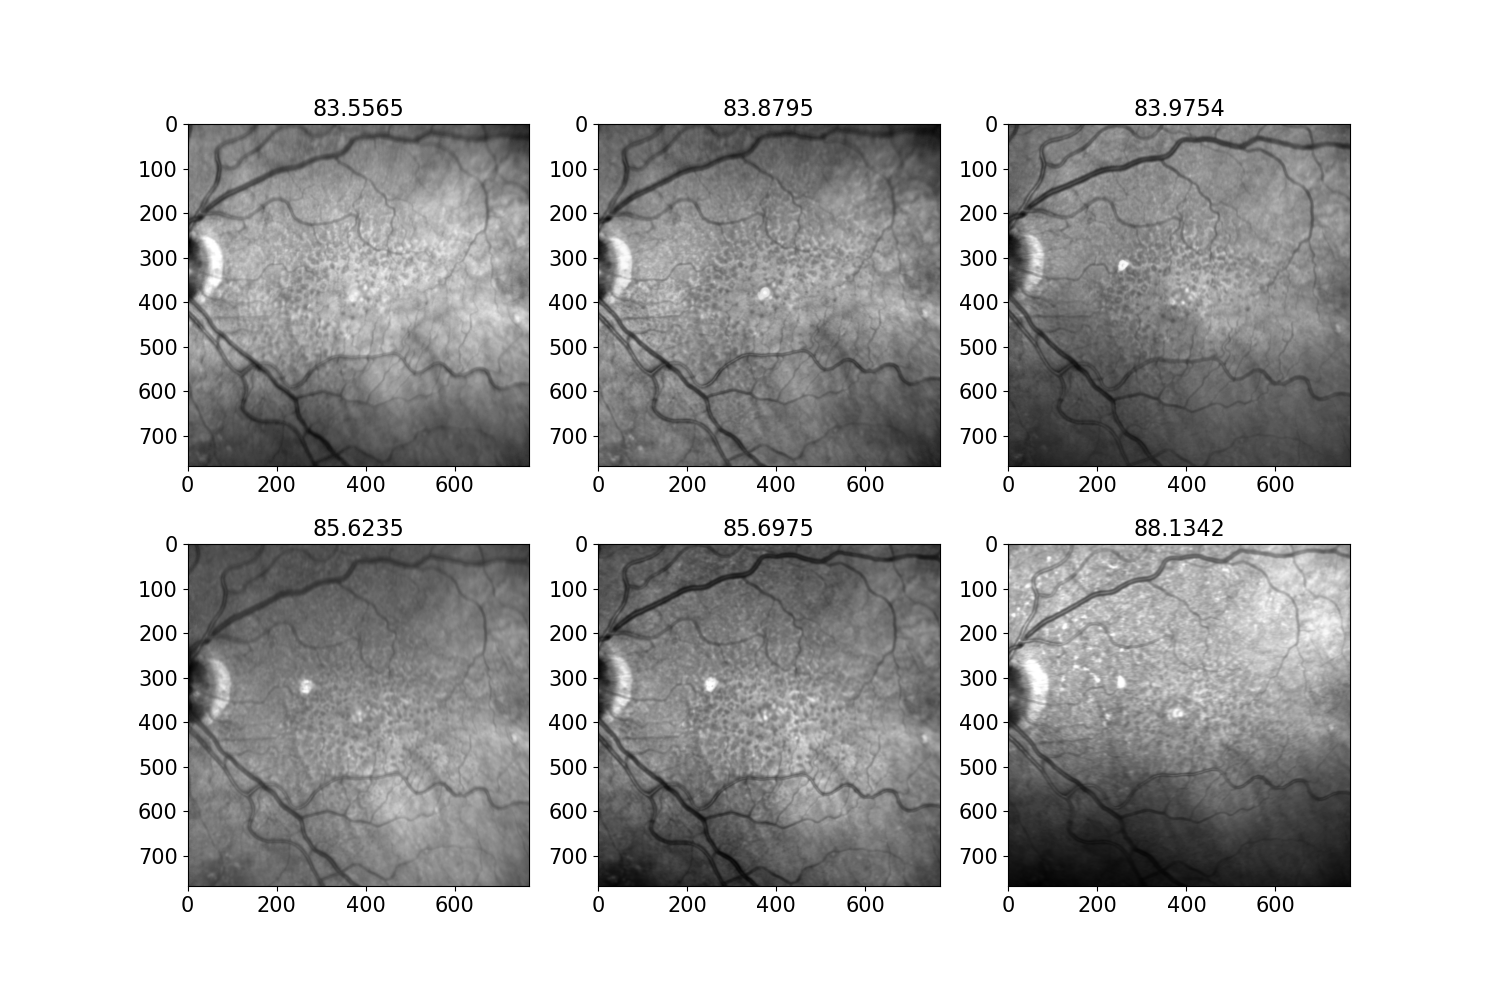

In [5]:
from PIL import Image
fig,axs = plt.subplots(2,3,figsize=[15,10])
irpaths = dict()
for ax,(name,grp) in zip(fig.axes,grps_L):
    dat = vis.get_gt_image_data(grp.index.values[0])
    irpath = os.path.join(os.path.dirname(dat['file_name']),'ir.png')
    irpaths[name] = irpath
    ax.imshow(Image.open(irpath),cmap='gray')
    ax.set_title(name)
    
irpaths

In [10]:
import cv2
import numpy as np

# Read the images to be aligned
im1 = cv2.imread(irpaths[83.5565])  # Reference image.
im2 = cv2.imread(irpaths[88.1342])  # Image to be aligned.  

# Convert images to grayscale
im1_gray = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

# Find size of image1
sz = im1.shape

# Define the motion model
warp_mode = cv2.MOTION_AFFINE 

# Define 2x3 or 3x3 matrices and initialize the matrix to identity
if warp_mode == cv2.MOTION_HOMOGRAPHY:
    warp_matrix = np.eye(3, 3, dtype=np.float32)
else:
    warp_matrix = np.eye(2, 3, dtype=np.float32)

# Specify the number of iterations.
number_of_iterations = 500;

# Specify the threshold of the increment
# in the correlation coefficient between two iterations
termination_eps = 1e-10;

# Define termination criteria
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

# Run the ECC algorithm. The results are stored in warp_matrix.
(cc, warp_matrix) = cv2.findTransformECC (im1_gray,im2_gray,warp_matrix, warp_mode, criteria)

if warp_mode == cv2.MOTION_HOMOGRAPHY:
    # Use warpPerspective for Homography
    im2_aligned = cv2.warpPerspective (im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR+ cv2.WARP_INVERSE_MAP)
else:
    # Use warpAffine for Translation, Euclidean and Affine
    im2_aligned = cv2.warpAffine(im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR+ cv2.WARP_INVERSE_MAP);


Text(0.5, 1.0, 'Image 2 Aligned')

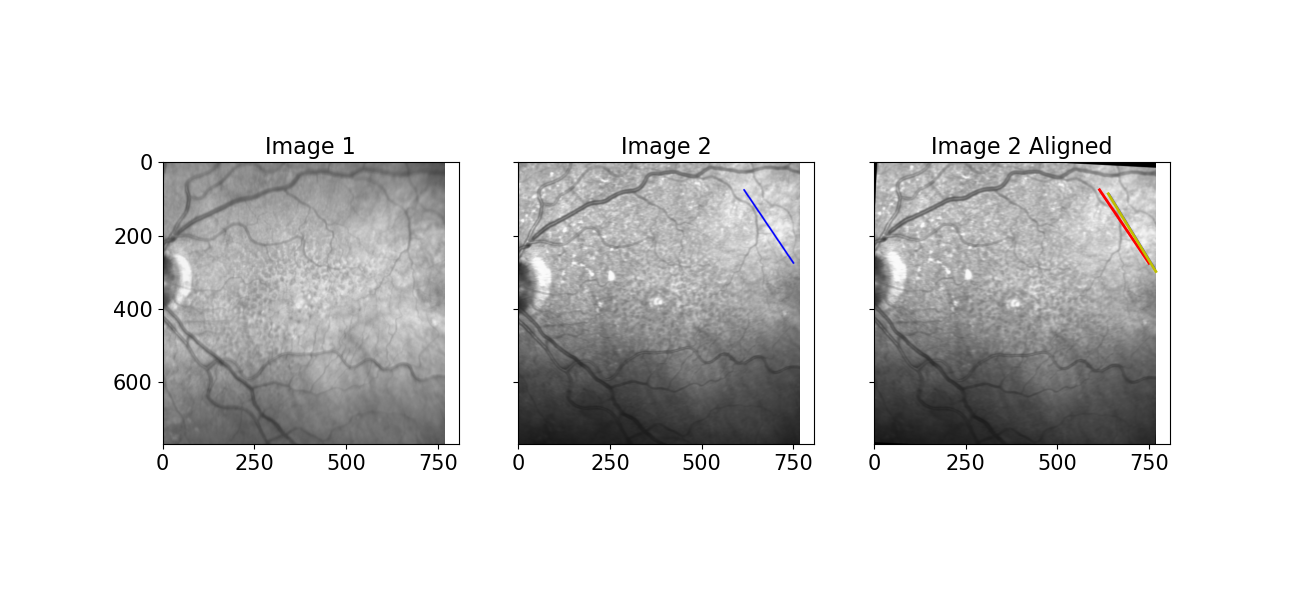

In [23]:

fig,ax = plt.subplots(1,3,figsize=[13,6],sharex=True,sharey=True)
# Show final results
ax[0].imshow(im1)
#ax[0].plot([615,750],[75,275],'r')
ax[0].set_title('Image 1')
#ax[1].imshow(im2)
im2p = cv2.line(im2,[615,75],[750,275],(0,0,255),3)
ax[1].imshow(im2p)
ax[1].set_title('Image 2')
im2_aligned = cv2.warpAffine(im2p, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);
ax[2].imshow(im2_aligned)
ax[2].plot([615,750],[75,275],'r')
trans = cv2.invertAffineTransform(warp_matrix)@np.array([[615,750],[75,275],[1,1]])
#trans = np.array([[1,0],[0,-1]])@warp_matrix@np.array([[615,750],[-75,-275],[0,0]]) + warp_matrix@np.array([[0,0],[0,0],[1,-1]])
ax[2].plot(trans[0],trans[1],'y')
ax[2].set_title('Image 2 Aligned')





In [21]:
Winv = np.linalg.inv(warp_matrix[:,:-1])


array([[ 1.0290676 , -0.04592602],
       [ 0.05389881,  1.0226426 ]], dtype=float32)

In [26]:
-Winv@warp_matrix[:,-1]

array([  9.527827, -23.982481], dtype=float32)

In [19]:
warp_matrix

array([[ 0.969473  ,  0.04353821, -8.192818  ],
       [-0.05109648,  0.975564  , 23.883286  ]], dtype=float32)

In [20]:
cv2.invertAffineTransform(warp_matrix)

array([[  1.0290678 ,  -0.04592602,   9.527829  ],
       [  0.05389882,   1.0226427 , -23.982485  ]], dtype=float32)

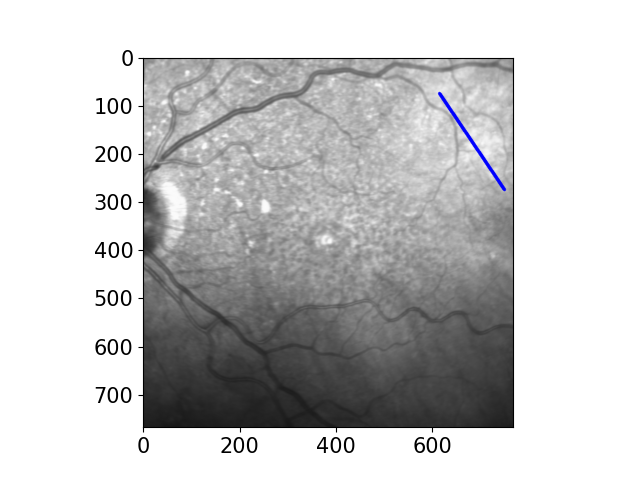

In [10]:
im2p = cv2.line(im2,[615,75],[750,275],(0,0,255),3)
fig,ax = plt.subplots(1,1)
ax.imshow(im2p)